**Lab assignment 1**

More advanced notebook aimed at making detailed comparisons between heuristics.

It includes graphical visualization and quantitative analysis to support the justification of
results.

# Analysing search algorithms
Statistical comparison between A* MD+LC and Greedy Manhattan over n random puzzles.

Metrics to compare:
- Cost of the solution (number of movements)
- Number of nodes expanded
- Execution time
- Difference between solutions

In [1]:
pip install matplotlib tabulate numpy


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import the required libraries
import search
from search import *
import time
import statistics
import matplotlib.pyplot as plt

## Setting up and running the experiment

In [3]:
# Auxiliary methods to execute the algorithms

def run_algorithm(algorithm_name, initial_state, end_state, size, depth=50, heuristic_func=None):
    """
    Executes the algorithm specified by its name and returns its results.
    Returns:
        dict: Dictionary with the results of the algorithm, or None if an error occurs
    """
    solution_data = None

    if algorithm_name == 'BFS':
        solution_data = graphSearch(initial_state, end_state, lambda x: 1, lambda s, es: 0, size)
        #print("BFS executed")

    elif algorithm_name == 'DFS (Graph Search)':
        solution_data = graphSearch(initial_state, end_state, lambda x: -1, lambda s, es: 0, size, maximum_depth=depth)
        #print("DFS (Graph Search) executed")

    elif algorithm_name == 'DFS-B':
        results_dict, _ = DFS_B(initial_state, end_state, size=size, maximum_depth=depth)
        solution_data = results_dict
        #print("DFS-B executed")

    elif algorithm_name == 'Voraz (Manhattan)':  # Greedy (Manhattan)
        manhattan_h_search = lambda s, es_local=end_state: getManhattanDistance(s, es_local)
        solution_data = graphSearch(initial_state, end_state, lambda x: 0, manhattan_h_search, size)
        #print("Voraz (Manhattan) executed")

    elif algorithm_name == 'ID':
        solution_data = ID_B(initial_state, end_state, size=size)
        #print("ID executed")

    elif algorithm_name == 'A* (Manhattan)':
        manhattan_h_search = lambda s, es_local=end_state: getManhattanDistance(s, es_local)
        solution_data = graphSearch(initial_state, end_state, lambda x: 1, manhattan_h_search, size)
        #print("A* (Manhattan) executed")

    elif algorithm_name == 'A (MD + LC)':
        md_lc_h_search = lambda s, es_local=end_state: get_md_plus_linear_conflict(s, es_local)
        solution_data = graphSearch(initial_state,end_state,  lambda x: 1, md_lc_h_search, size)
        #print("A (Manhattan + Linear_conflict) executed")

    elif algorithm_name == 'IDA* (Manhattan)':
        manhattan_h_search = lambda s, es_local=end_state: getManhattanDistance(s, es_local)
        solution_data = IDA_B(initial_state, end_state, size, manhattan_h_search)
        #print("IDA* (Manhattan) executed")

# =======================================================
    elif algorithm_name == 'Misplaced tiles':
        solution_data = graphSearch(initial_state, end_state, lambda x: 1, 
                                    lambda s, es: misplaced_tiles(s, end_state), size)
        print("Misplaced tiles executed")
    
    elif algorithm_name == 'Rows Columns':
        solution_data = graphSearch(initial_state, end_state, lambda x:1, 
                                    lambda s, es: rows_columns(s, end_state), size)
        print("Rows Columns executed")
    elif algorithm_name == 'A* Euclidean':
        solution_data = graphSearch(initial_state, end_state, lambda x:1, 
                                    lambda s, es: a_euclidean(s, end_state), size)
        print("A*Euclidean executed")
    elif algorithm_name == 'A* Euclidean + LC':
        solution_data = graphSearch(initial_state, end_state, lambda x:1, 
                                    lambda s, es: a_euclidean_lc(s, end_state), size)
        print("A*Euclidean + LC executed")

    elif algorithm_name == 'Voraz (A*Euclidean + LC)':  # Greedy (A*Euclidean + LC)
        a_euclidean_lc_h_search = lambda s, es_local=end_state: a_euclidean_lc(s, es_local)
        solution_data = graphSearch(initial_state, end_state, lambda x: 0, a_euclidean_lc_h_search, size)
        print("Voraz (A*Euclidean + LC) executed")
# ========================================================

    else:
        print(f"Algorithm {algorithm_name} not found!")
        return None

    if solution_data:
        if not solution_data['path'] or len(solution_data['path']) == 0:
            print(f"No solution found for {algorithm_name}")
        return {algorithm_name: solution_data}
    else:
        print(f"No solution data returned for {algorithm_name}")
        return {algorithm_name: {}}  # Return empty dict for the algorithm


def run_all_algorithms(initial_state, end_state, size, depth = 50):
    """
    Executes all the algorithms defined and returns their results.
    Returns:
        dict: Dictionary with the results of all the algorithms executed
    """
    algorithms = [
        'BFS',
        'DFS-B',
        'Voraz (Manhattan)',  # Greedy (Manhattan)
        'ID',
        'A* (Manhattan)',
        'A (MD + LC)',
        'IDA* (Manhattan)',
        'Misplaced tiles',
        'Rows Columns',
        'A* Euclidean',
        'A* Euclidean + LC',
        'Voraz (A*Euclidean + LC)'
    ]

    results = {}
    seen_algos = set()
    for algo in algorithms:
        if algo not in seen_algos:
            seen_algos.add(algo)
            algo_result = run_algorithm(algo, initial_state, end_state, size, depth)
            if algo_result and algo in algo_result:
                results[algo] = algo_result[algo]

    return results

In [4]:
# Setup
size = 3  # Puzzle size
num_iterations = 1000  # Number of random puzzles
end_state = generate_spiral_state(size)

# Structures to store the results
astar_costs = []
astar_expanded = []
astar_times = []
greedy_costs = []
greedy_expanded = []
greedy_times = []
cost_differences = []
time_differences = []

print(f"Initiating experiment with {num_iterations} puzzles of size {size}x{size}")
print("Goal state:")
visualize_state(end_state)

# Main loop of the experiment
for i in range(num_iterations):
    # Generating random initial state
    initial_state = generate_random_state(size, end_state)

    if not isSolvable(initial_state, end_state):
        print(f"\nPuzzle {i+1}: There is no solution, generating one more...")
        continue

    print(f"\rProcessing puzzle {i+1}/{num_iterations}", end='', flush=True)

    # A* MD + LC

    result = run_algorithm('A (MD + LC)', initial_state, end_state, size)

    astar_result = result['A (MD + LC)']

    # Greedy Manhattan

    result = run_algorithm('Voraz (Manhattan)', initial_state, end_state, size)

    greedy_result = result['Voraz (Manhattan)']

    # Saving the results

    astar_costs.append(astar_result['cost'])
    astar_expanded.append(astar_result['nodes_expanded'])
    astar_times.append(astar_result['time'])

    greedy_costs.append(greedy_result['cost'])
    greedy_expanded.append(greedy_result['nodes_expanded'])
    greedy_times.append(greedy_result['time'])

    cost_diff = greedy_result['cost'] - astar_result['cost']
    cost_differences.append(cost_diff)

    time_diff = astar_result['time'] - greedy_result['time']
    time_differences.append(time_diff)



print("\nExperiment completed!")

Initiating experiment with 1000 puzzles of size 3x3
Goal state:
 1  2  3
 8     4
 7  6  5
Processing puzzle 1/1000

Processing puzzle 1000/1000
Experiment completed!


## Analysing the results

In [5]:
# Computing statistics
stats = {
    'A*': {
        'coste_min': min(astar_costs),  # Minimum cost
        'coste_max': max(astar_costs),  # Maximum cost
        'coste_medio': statistics.mean(astar_costs),  # Mean cost
        'expandidos_medio': statistics.mean(astar_expanded),  # Mean number of nodes expanded
        'tiempo_medio': statistics.mean(astar_times)  # Mean time
    },
    'Voraz': {  # Greedy
        'coste_min': min(greedy_costs),  # Minimum cost
        'coste_max': max(greedy_costs),  # Maximum cost
        'coste_medio': statistics.mean(greedy_costs),  # Mean cost
        'expandidos_medio': statistics.mean(greedy_expanded),  # Mean number of nodes expanded
        'tiempo_medio': statistics.mean(greedy_times)  # Mean time
    }
}

print("Statistics for A* MD LC:")
print(f"Cost - Min: {stats['A*']['coste_min']}, Max: {stats['A*']['coste_max']}, Mean: {stats['A*']['coste_medio']:.2f}")
print(f"Nodes expanded (mean): {stats['A*']['expandidos_medio']:.2f}")
print(f"Mean time: {stats['A*']['tiempo_medio']:.3f}s\n")

print("Statistics for Greedy Manhattan:")
print(f"Cost - Min: {stats['Voraz']['coste_min']}, Max: {stats['Voraz']['coste_max']}, Mean: {stats['Voraz']['coste_medio']:.2f}")
print(f"Nodes expanded (mean): {stats['Voraz']['expandidos_medio']:.2f}")
print(f"Mean time: {stats['Voraz']['tiempo_medio']:.3f}s\n")

print("Cost differences (Greedy - A*):")
print(f"Minimum: {min(cost_differences)}")
print(f"Maximum: {max(cost_differences)}")
print(f"Mean: {statistics.mean(cost_differences):.2f}")

Statistics for A* MD LC:
Cost - Min: 4, Max: 29, Mean: 21.57
Nodes expanded (mean): 295.29
Mean time: 0.011s

Statistics for Greedy Manhattan:
Cost - Min: 4, Max: 99, Mean: 51.58
Nodes expanded (mean): 276.93
Mean time: 0.004s

Cost differences (Greedy - A*):
Minimum: 0
Maximum: 78
Mean: 30.01


## Visualizing the results

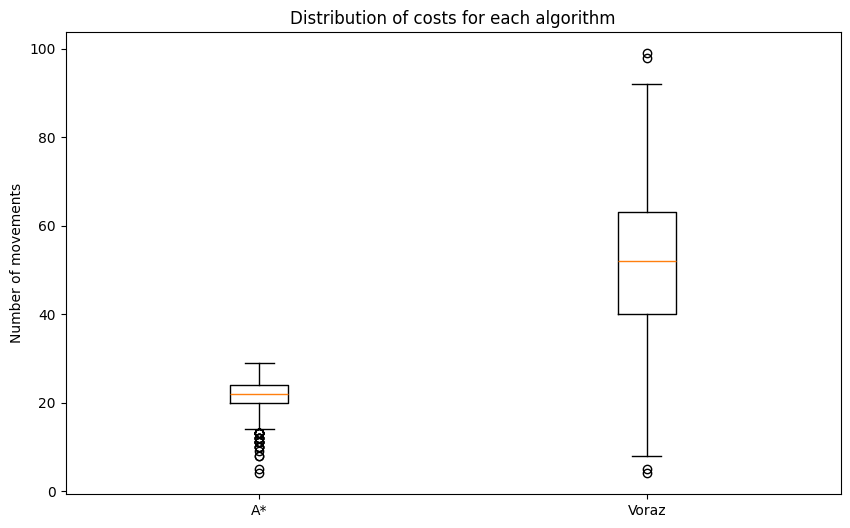

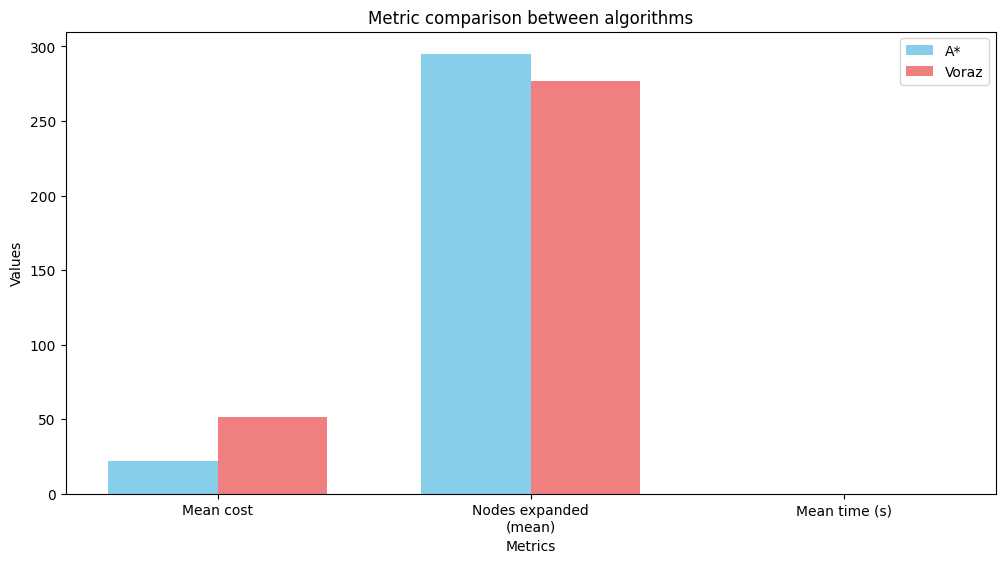

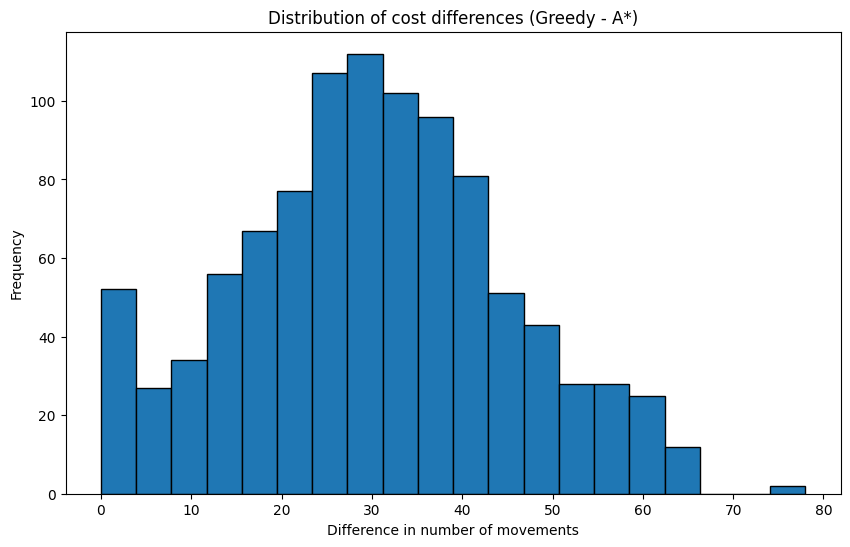

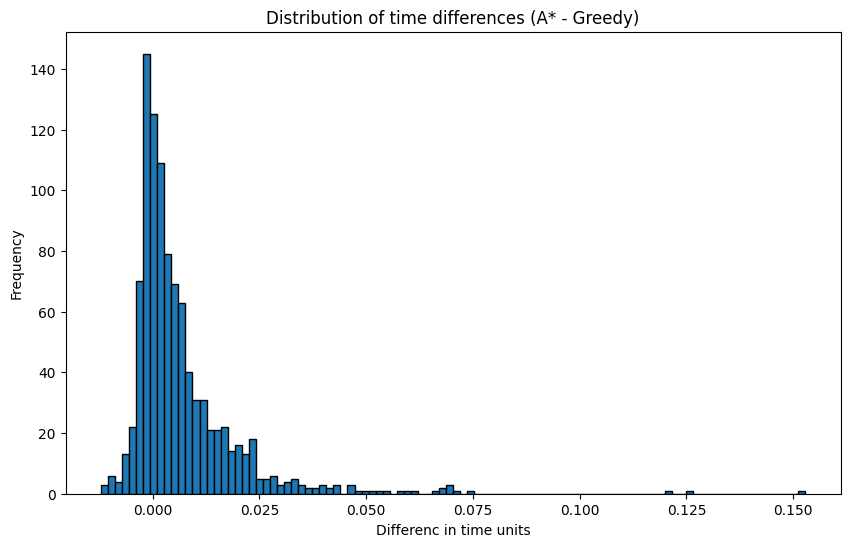

In [6]:
# Box plot for costs
plt.figure(figsize=(10, 6))
plt.boxplot([astar_costs, greedy_costs])
plt.title('Distribution of costs for each algorithm')
plt.ylabel('Number of movements')
plt.xticks([1, 2], ['A*', 'Voraz'])  # ← Here you indicate the labels
plt.show()

# Bar chart for mean stats
metrics = ['Mean cost', 'Nodes expanded\n(mean)', 'Mean time (s)']
astar_values = [stats['A*']['coste_medio'], stats['A*']['expandidos_medio'], stats['A*']['tiempo_medio']]
greedy_values = [stats['Voraz']['coste_medio'], stats['Voraz']['expandidos_medio'], stats['Voraz']['tiempo_medio']]

plt.figure(figsize=(12, 6))
x = range(len(metrics))
width = 0.35

plt.bar([i - width/2 for i in x], astar_values, width, label='A*', color='skyblue')
plt.bar([i + width/2 for i in x], greedy_values, width, label='Voraz', color='lightcoral')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Metric comparison between algorithms')
plt.xticks(x, metrics)
plt.legend()
plt.show()

# Histogram of cost differences
plt.figure(figsize=(10, 6))
plt.hist(cost_differences, bins=20, edgecolor='black')
plt.title('Distribution of cost differences (Greedy - A*)')
plt.xlabel('Difference in number of movements')
plt.ylabel('Frequency')
plt.show()

# Histogram of cost differences
plt.figure(figsize=(10, 6))
plt.hist(time_differences, bins=100, edgecolor='black')
plt.title('Distribution of time differences (A* - Greedy)')
plt.xlabel('Differenc in time units')
plt.ylabel('Frequency')
plt.show()

7. A DETAILED COMPARISON OF THE 2 BEST HEURSITICS YOU HAVE IDENTIFIED: A*(Manhattan-LC) and Greedy(Manhattan)

When comparing the average cost of execution of both algorithms, we can observer that A*(MD+LC) performs far better than Greedy(MD), having less movements and being more consistence than the Greedy algorithm, as we can see by observing the values of their means (A*: 21.57, Greedy: 51.58) and their maximum values (A*: 29, Greedy: 99). However, Greedy outperforms A* with respect to the number of nodes expanded/generated (276.93 of Greedy in front of the 295.29 of A*) and, more importantly, in the execution time, taking Greedy 0.007s less time to execute than A*. 
In summary, while Greedy might take a greater average movement number than A*, both the number of memory used (nodes generated) and time needed for execution are better than the ones from A* algorithm.
